# Predicting Housing Prices in Ames, Iowa

To better understand the housing market in Ames we will create a regression model to predict the 
sale price of any given house by analyzing certain features of that house. By comparing the predicted 
sale price to a list of known sale prices of houses with the same features, we can test our model and 
assign a score to the results. This can then be used to judge whether or not the price of a house for
sale is in line with what it should be, or to come up with a price for a new listing.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso, Ridge, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from wand.image import Image
from wand.color import Color


### Load and Clean Data

In [2]:
# Load in data from CSV
kaggle = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

Spaces should be underscores and column names should be all lowercase to make things easier to type

In [3]:
for df in [train,kaggle]:
    df.columns = [col.lower().replace(' ','_') for col in df.columns]

### Discovery
Let's figure out what we're going to feed into the model. [The dictionary can be found here](data/dictionary.txt)<br>
First let's make a function to make plotting easier.

In [8]:
sns.set_context('talk')
sns.set_style('darkgrid')
def discover_plot(x,y):
    figname = str(x[0])+str(y[0])+'.svg'
    return sns.jointplot(y=y, x=x,
                      kind="reg", truncate=False,
                      color='crimson', height=7,
                       ).savefig(figname, backend='Cairo')

In [5]:
gr_liv = str(train.gr_liv_area[0])+str(train.saleprice[0])+'.png'

In [102]:
with Image(filename=gr_liv) as img:
    img.
    img.save(filename='edge-pl1.png')

SyntaxError: invalid syntax (3671886240.py, line 2)

In [103]:
train.gr_liv_area.info()

<class 'pandas.core.series.Series'>
Int64Index: 2047 entries, 0 to 2050
Series name: gr_liv_area
Non-Null Count  Dtype
--------------  -----
2047 non-null   int64
dtypes: int64(1)
memory usage: 96.5 KB


Above grade living area sounds like a feature with lots of influence and has no nulls. A low hanging fruit

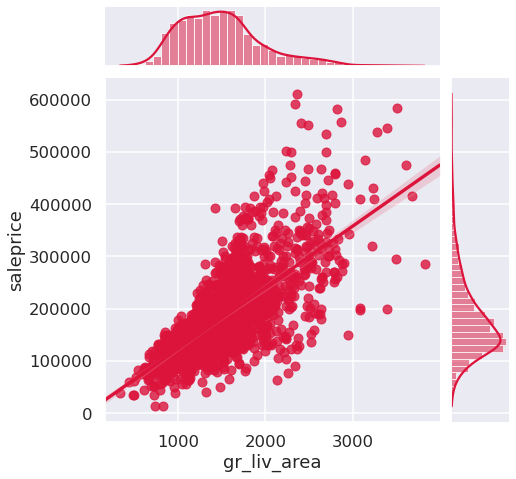

In [104]:
discover_plot(train.gr_liv_area,train.saleprice);

It looks decent, the correlation is linear and distributions are of desirable shape. But the two outliers will probably be an issue

We can make a function to drop any outliers above a certain threshold

In [6]:
def drop_outliers(dflist,feature,threshold):
    for df in dflist:
        df.drop(df[feature][df[feature]>threshold].keys(),inplace=True)

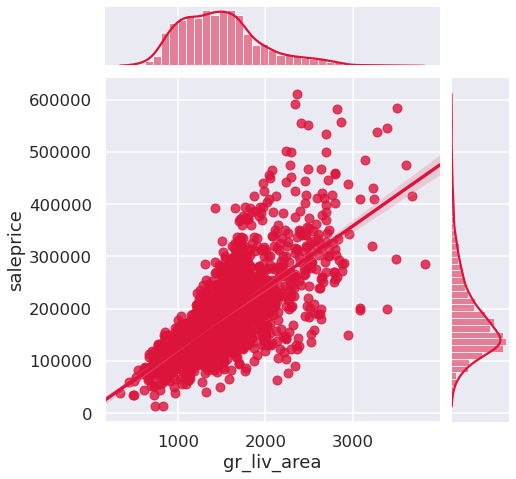

In [9]:
drop_outliers([train],'gr_liv_area',4500)
discover_plot(train.gr_liv_area,train.saleprice);

As living area increases, so does sale price

By subtracting the year a house was built from the year it was sold, we can get the age of a house at its point of sale and use this in our model

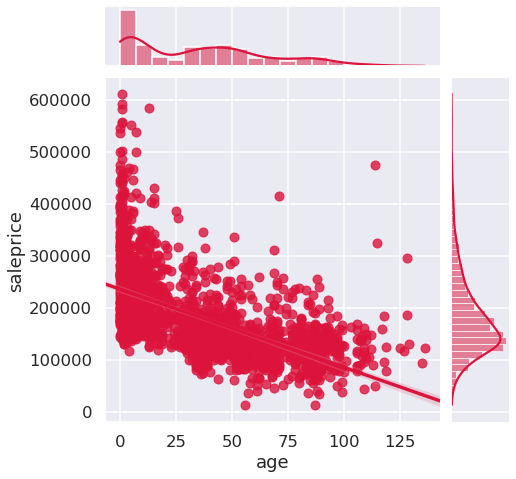

In [107]:
for df in [train,kaggle]:
    df['age'] = [df.iloc[i]['yr_sold'] - df.iloc[i]['year_built'] for i in range(len(df))]

discover_plot(train.age,train.saleprice);

As a house ages, its value goes down

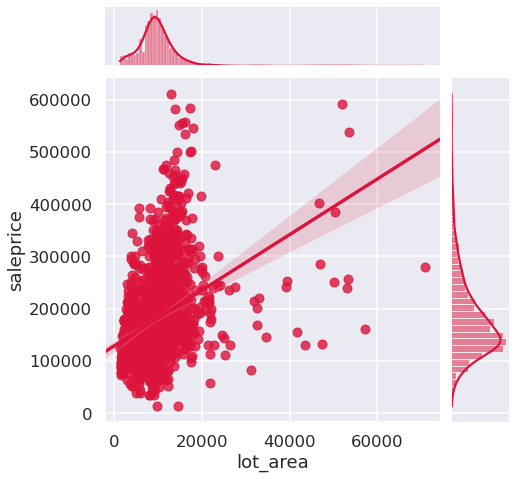

In [108]:
discover_plot(train.lot_area, train.saleprice);

Sale price increases with lot area as well, but we have the same problem with outliers

In [109]:
drop_outliers([train],'lot_area',80000)

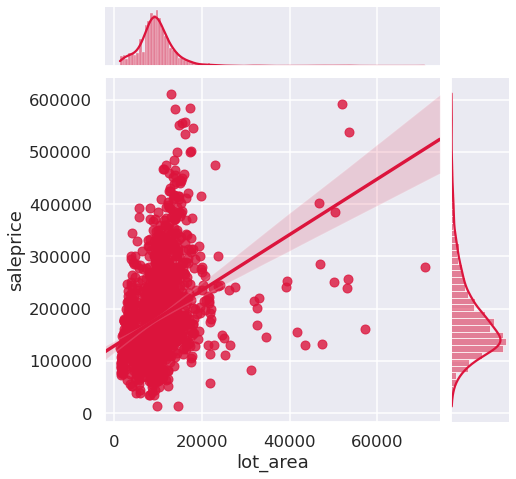

In [110]:
discover_plot(train.lot_area, train.saleprice);

This is a clearer picture. There is still some noise but the scaler should be able to handle the rest

### Create a DataFrame for the model
Now split off price (our target) as y and list features to be included in the feature set (X) for our model. 
Also create X_kaggle for creating a kaggle submission later on

In [151]:
y = train.saleprice

include = [
    'gr_liv_area',
    'age',
    'lot_area',
    'neighborhood',
    'central_air',
    'overall_qual',
    'fireplaces',
    'full_bath',
    'half_bath',
    'ms_zoning',
    'street',
    # 'low_qual_fin_sf',
    'land_contour',
    'lot_config',
    # 'overall_cond', # points the wrong way
          ] 
X = train[include]
X_kaggle = kaggle[include]

From the selected features, anything that is an object we'll just convert to dummies and then drop the original column

In [152]:
# convert all object type columns into dummies
def make_dummies(df):
    for col_name in df.columns:
        if df[col_name].dtype == 'O':
            dums = pd.get_dummies(df[col_name],prefix=col_name,dtype=int,drop_first=True)
            df = df.drop(labels=[col_name],axis=1)
            df = df.join(dums)
    return df

X = make_dummies(X)
X_kaggle = make_dummies(X)

The block below can be expanded to show a plot of the linearity of every feature used in the model and provide some insight as to how each feature affects the predicted sale price

In [153]:
# for col in X.columns:
#     discover_plot(X[col],y)
#     plt.show()

### Noteworthy Discoveries

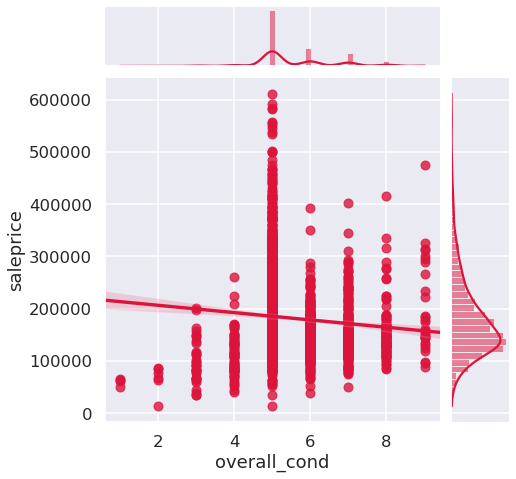

In [154]:
discover_plot(train.overall_cond,y);

This feature is actually the opposite of what you may expect... As overall condition goes up, the price goes down? I think someone is lying!

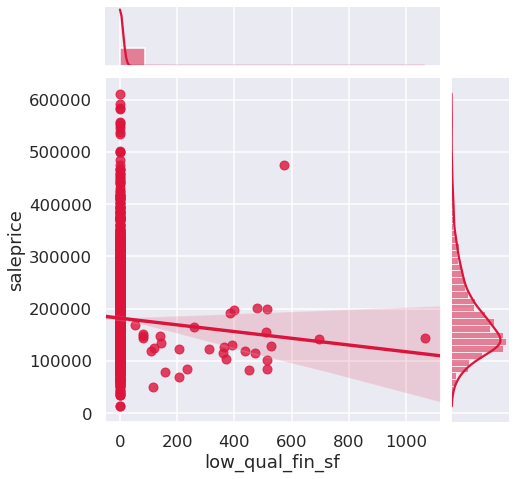

In [155]:
discover_plot(train.low_qual_fin_sf,y);

Here's an example of a feature I think is just useless, not enough meaningful data to be included

The data set isn't huge, so we'll use a 60/40 split to try to balance representation between testing and training sets. By not specifying a random seed we can get a slightly different result each time we run the split, but since the split is defined seperately from the model, each model runs on the same data split with the same random seed. In other words, the more we split and run models, we can see how consistent the model is. This Model is quite consistent in my testing

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

And then run the model, first just a basic LinearRegression

In [157]:
pipe = Pipeline([
    ('scale', QuantileTransformer()),
    ('model', LinearRegression())
])
model = pipe.fit(X_train,y_train)
test_predict = model.predict(X_test)
train_predict = model.predict(X_train)
print(f'\
--Test--\n\
RMSE: {mean_squared_error(y_test, test_predict ,squared=False):.2f}\n\
R2 Score: {r2_score(y_test, test_predict):.2f}\n\n\
--Train--\n\
RMSE: {mean_squared_error(y_train, train_predict ,squared=False):.2f}\n\
R2 Score: {r2_score(y_train, train_predict):.2f}\
')

--Test--
RMSE: 37720.42
R2 Score: 0.79

--Train--
RMSE: 32402.64
R2 Score: 0.82


Calculating the Root Mean Squared Error will show us on average how far off our prediction is in USD. Here we're off by an amount in the mid $30,000s on average.<br>
The R2 scores show how good of a fit we have to the data. As you can see they're about equal, indicating a possible overfit. This model may not perform well with unseen data.<br>
Next try a Lasso

In [158]:
pipe = Pipeline([
    ('scale', QuantileTransformer()),
    ('model', LassoCV())
])
model = pipe.fit(X_train,y_train)
test_predict = model.predict(X_test)
train_predict = model.predict(X_train)
print(f'\
--Test--\n\
RMSE: {mean_squared_error(y_test, test_predict ,squared=False):.2f}\n\
R2 Score: {r2_score(y_test, test_predict):.2f}\n\n\
--Train--\n\
RMSE: {mean_squared_error(y_train, train_predict ,squared=False):.2f}\n\
R2 Score: {r2_score(y_train, train_predict):.2f}\
')

--Test--
RMSE: 37768.26
R2 Score: 0.79

--Train--
RMSE: 32467.83
R2 Score: 0.82


And now a Ridge

In [159]:
pipe = Pipeline([
    ('scale', QuantileTransformer()),
    ('model', RidgeCV())
])
model = pipe.fit(X_train,y_train)
test_predict = model.predict(X_test)
train_predict = model.predict(X_train)
print(f'\
--Test--\n\
RMSE: {mean_squared_error(y_test, test_predict ,squared=False):.2f}\n\
R2 Score: {r2_score(y_test, test_predict):.2f}\n\n\
--Train--\n\
RMSE: {mean_squared_error(y_train, train_predict ,squared=False):.2f}\n\
R2 Score: {r2_score(y_train, train_predict):.2f}\
')

--Test--
RMSE: 37818.28
R2 Score: 0.79

--Train--
RMSE: 32482.25
R2 Score: 0.82


There is hardly any difference in output, I believe due to the relatively clean input and the type of scaling applied. This can be demonstrated below. Brighter dots are higher price predictions

In [160]:
def model_scatter(x,y):
    figname = str(x)+'-'+str(y)+'.png'
    f, ax = plt.subplots(figsize=(8, 7))
    plt.scatter(X_trans[:,x], X_trans[:,y], c=new_predict, cmap='rocket_r', alpha=0.5)
    plt.xlabel(X.columns[x])
    plt.ylabel(X.columns[y])
    plt.title('Predicted Sale Price')
    f.savefig(figname, backend='Cairo')
    plt.show()

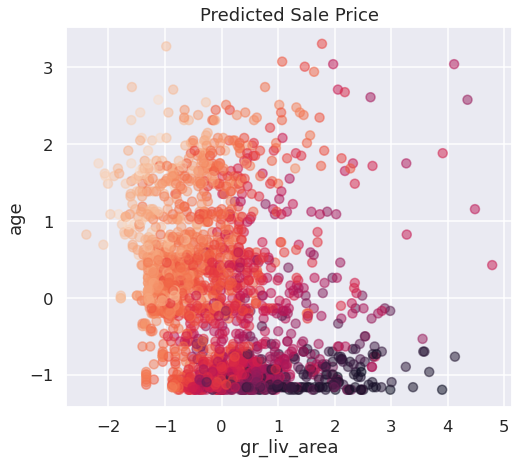

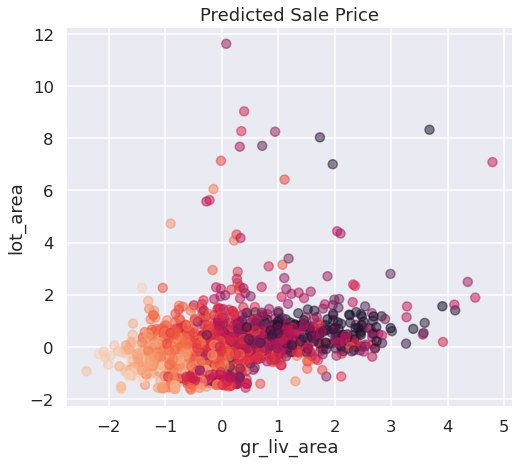

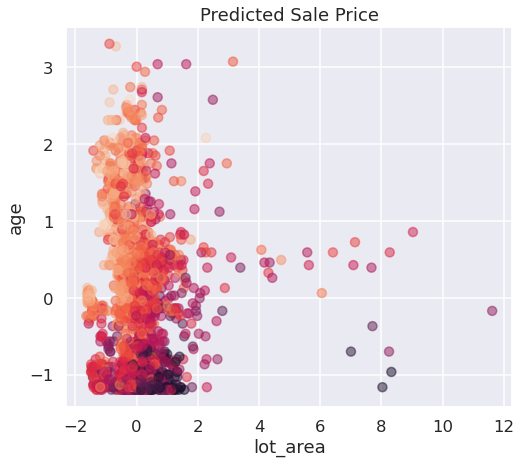

In [161]:
new_predict = model.predict(X)
X_trans = StandardScaler().fit_transform(X)

model_scatter(0,1)
model_scatter(0,2)
model_scatter(2,1)

If you stare at it long enough you can make some sense of it, but it's not a clear picture. You don't get the full story.<br>
But if we change the scaler...

In [162]:
X_trans

array([[-0.03310339, -0.06938842,  0.6904143 , ..., -0.17377076,
        -0.0664537 , -1.66010942],
       [ 1.2909327 , -0.76451772,  0.30382328, ..., -0.17377076,
        -0.0664537 , -1.66010942],
       [-0.90206642,  0.69194368, -0.37772237, ..., -0.17377076,
        -0.0664537 ,  0.60236993],
       ...,
       [ 0.86056949,  1.48637717, -0.4472133 , ..., -0.17377076,
        -0.0664537 ,  0.60236993],
       [-0.60760739,  0.5595381 ,  0.09535049, ..., -0.17377076,
        -0.0664537 , -1.66010942],
       [ 0.63612169, -0.83072051, -0.45828603, ..., -0.17377076,
        -0.0664537 ,  0.60236993]])

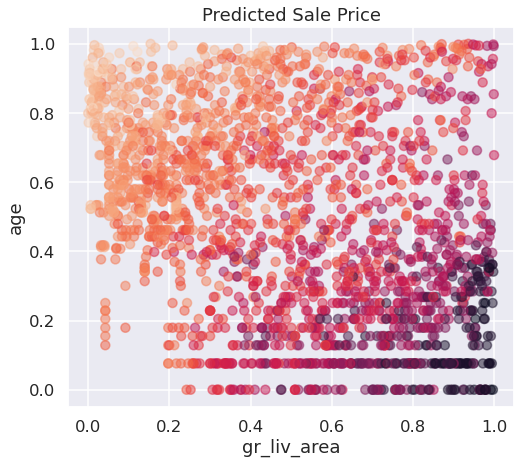

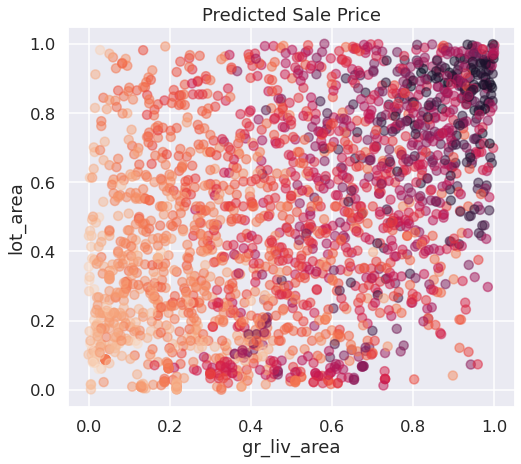

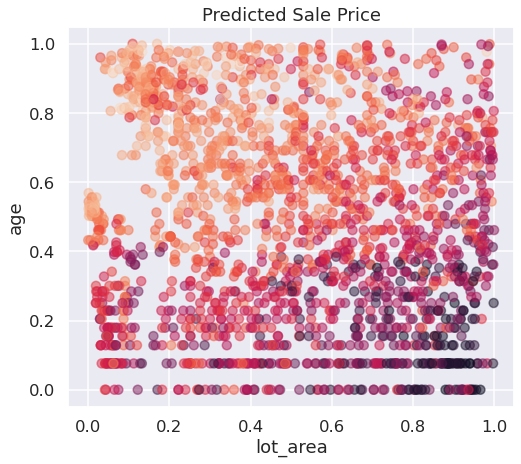

In [163]:
X_trans = QuantileTransformer().fit_transform(X)

model_scatter(0,1)
model_scatter(0,2)
model_scatter(2,1)

The quantile transformer scales the data based on quantiles, reducing the effect of outliers and creating a clear picture of the data. You can clearly see
for instance in the first picture that the predicted sale price for an old shed is the lowest, and a new mansion is worth lots of money. The model can see this clearer as well

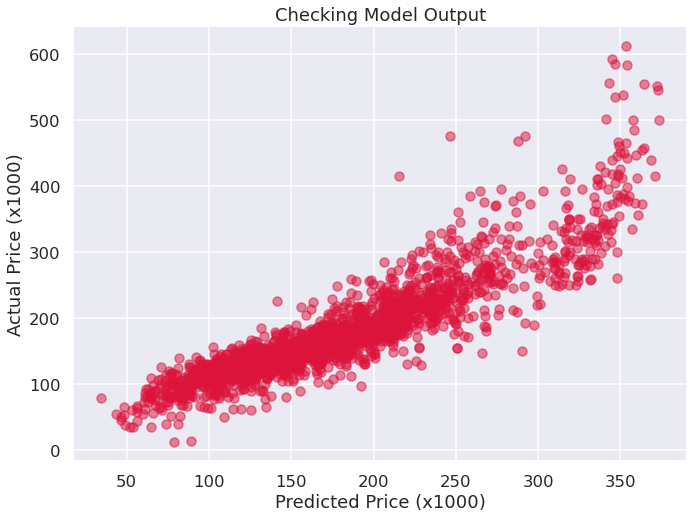

In [164]:

f, ax = plt.subplots(figsize=(11, 8))
plt.scatter(new_predict/1000,y/1000, alpha=0.5, color='crimson')
plt.xlabel('Predicted Price (x1000)')
plt.ylabel('Actual Price (x1000)')
plt.title('Checking Model Output')
f.savefig('mod_out.png', backend='Cairo')
plt.show()


The model seems to be a little fuzzy working with higher prices. But this is about the shape we're looking for. "Perfect" would be a solid straight line

Finally, output results to csv for kaggle submission

In [165]:
results = pd.DataFrame(kaggle.pid)
kpredict = model.predict(X_kaggle)
results['SalePrice'] = pd.Series(kpredict)
results.columns = ['Id','SalePrice']
results.to_csv('data/results.csv',index=False)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         878 non-null    int64  
 1   SalePrice  878 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.8 KB


### Conclusion

This model was designed with a focus on quality and consistency. With some more refinement the margin of error should be able to be reduced
to a reasonable number and reliable, accurate predictions can be made for any application where there is a need to assess the value of a property.<br>
I think a big limiting factor here is the size of the data set compared to quality of the features provided. There are more features from this data set
that can be added but I think the biggest gains will be had from simply feeding in more data for the chosen features. The new added features will also
scale with more data. As you stray from the "low hanging fruit" features the quality of your data starts to go down: 

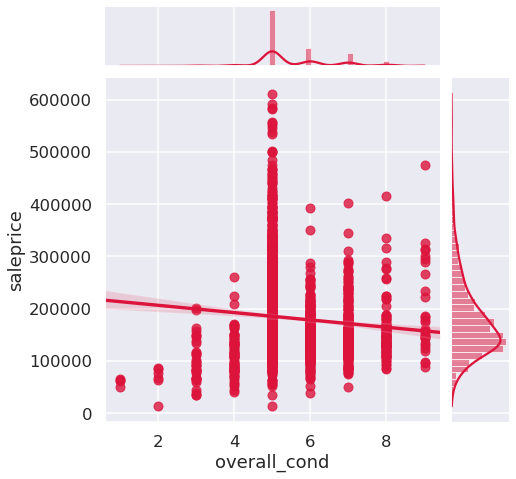

In [166]:
discover_plot(train.overall_cond,y);

In the case of overall condition of property, everyone wants to say their house is of highest condition and most houses sold are sold for less money than the mean of all sales prices. So this will drive the score down and skew predictions